In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/home/obesity')
from obesity.snp_encoding_traintest_split import snp_fast_encoding_and_labeling
from obesity.model import dense_model
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
train_obesity_snp_data_path = '/home/obesity/snp_data/snp_data_20210429/train_0002_obesity_SNP_5241_#_3786.tsv'
train_normal_snp_data_path = '/home/obesity/snp_data/snp_data_20210429/train_0002_normal_SNP_5241_#_29092.tsv'
valid_obesity_snp_data_path = '/home/obesity/snp_data/snp_data_20210429/valid_0002_obesity_SNP_5241_#_414.tsv'
valid_normal_snp_data_path = '/home/obesity/snp_data/snp_data_20210429/valid_0002_normal_SNP_5241_#_3227.tsv'
test_obesity_snp_data_path = '/home/obesity/snp_data/snp_data_20210429/test_0002_obesity _SNP_5241_#_641.tsv'
test_normal_snp_data_path = '/home/obesity/snp_data/snp_data_20210429/test_0002_normal _SNP_5241_#_4321.tsv'

In [4]:
train_data, train_labels = snp_fast_encoding_and_labeling(train_normal_snp_data_path, train_obesity_snp_data_path)
valid_data, valid_labels = snp_fast_encoding_and_labeling(valid_normal_snp_data_path, valid_obesity_snp_data_path)
test_data, test_labels = snp_fast_encoding_and_labeling(test_normal_snp_data_path, test_obesity_snp_data_path)

In [5]:
from tensorflow.keras.utils import to_categorical
train_data_onehot = to_categorical(train_data)
valid_data_onehot = to_categorical(valid_data)

In [6]:
valid_data_onehot.shape

(3641, 5241, 11)

In [7]:
from tensorflow.keras.layers import Concatenate, BatchNormalization
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout,Softmax
from tensorflow.keras.layers import Embedding,Reshape
from tensorflow.keras.layers import Input,Flatten
from tensorflow.keras.layers import LeakyReLU,RepeatVector
from tensorflow.keras import Model
from tensorflow.keras import optimizers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses

class Autoencoder(tf.keras.Model):
    def __init__(self,train_data):
        super().__init__()
        n_cols = train_data.shape[1]
        input_ = Input(shape=(n_cols,11))
        #Input layer
        # e = Embedding(11, 8)(input_)
        e = Flatten()(input_)
        #Encodeing
        x = BatchNormalization(center=False,scale=False)(LeakyReLU()(Dense(1024)(e)))
        embedding = BatchNormalization(center=False,scale=False,name='embedding')(LeakyReLU()(Dense(256)(x)))
        #Decoding
        x = BatchNormalization(center=False,scale=False)(LeakyReLU()(Dense(1024)(embedding)))
        x = Dense(n_cols*11, activation='linear')(x)
        x = Reshape((n_cols,11))(x)
        output_ = Softmax(axis=2)(x)
        self.model = tf.keras.Model(input_,output_)
        self.build((1,n_cols,11))
    
    def summary(self,show_detail=False):
        if show_detail:
            return self.model.summary()
        else: 
            return super().summary()
        
    def call(self, inputs, training=None):
        x = self.model(inputs,training)     
        return x

In [9]:
e = Autoencoder(train_data_onehot)
e.summary(show_detail=True)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5241, 11)]        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57651)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              59035648  
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)              

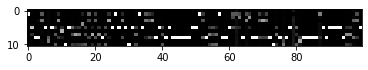

In [22]:
plt.imshow(e(train_data_onehot[1].reshape(1,5241,11))[0].numpy().transpose()[:,:100])
plt.gray()

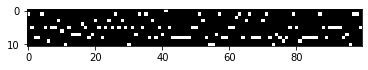

In [23]:
plt.imshow(train_data_onehot[1].reshape(1,5241,11)[0].transpose()[:,:100])
plt.gray()

In [10]:
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                              patience=50,verbose=1)
e_s = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      patience=150,
                                      verbose=0, mode='min')

In [11]:
e.model.compile(optimizer = optimizers.Adam(lr=1e-4), loss=losses.MeanSquaredError())
e.model.fit(train_data_onehot,train_data_onehot,
            batch_size= 1500,epochs=1000,
            shuffle=True,
            validation_data=(valid_data_onehot, valid_data_onehot),
            callbacks=[reduce_lr, e_s])

Epoch 1/1000
22/22 [==============================] - 10s 456ms/step - loss: 0.0829 - val_loss: 0.0826
Epoch 2/1000
22/22 [==============================] - 19s 858ms/step - loss: 0.0828 - val_loss: 0.0826
Epoch 3/1000
22/22 [==============================] - 19s 863ms/step - loss: 0.0826 - val_loss: 0.0824
Epoch 4/1000
22/22 [==============================] - 18s 810ms/step - loss: 0.0805 - val_loss: 0.0789
Epoch 5/1000
22/22 [==============================] - 16s 720ms/step - loss: 0.0674 - val_loss: 0.0611
Epoch 6/1000
22/22 [==============================] - 16s 743ms/step - loss: 0.0598 - val_loss: 0.0601
Epoch 7/1000
22/22 [==============================] - 17s 769ms/step - loss: 0.0590 - val_loss: 0.0594
Epoch 8/1000
22/22 [==============================] - 17s 783ms/step - loss: 0.0588 - val_loss: 0.0596
Epoch 9/1000
22/22 [==============================] - 17s 782ms/step - loss: 0.0587 - val_loss: 0.0598
Epoch 10/1000
22/22 [==============================] - 17s 781ms/step - l

22/22 [==============================] - 18s 831ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 79/1000
22/22 [==============================] - 19s 858ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 80/1000
22/22 [==============================] - 19s 845ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 81/1000
22/22 [==============================] - 19s 844ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 82/1000
22/22 [==============================] - 19s 851ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 83/1000
22/22 [==============================] - 19s 861ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 84/1000
22/22 [==============================] - 18s 828ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 85/1000
22/22 [==============================] - 19s 853ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 86/1000
22/22 [==============================] - 18s 823ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 87/1000
22/22 [==============================] - 18s 811ms/step - loss: 

Epoch 155/1000
22/22 [==============================] - 13s 572ms/step - loss: 0.0478 - val_loss: 0.0484
Epoch 156/1000
22/22 [==============================] - 15s 674ms/step - loss: 0.0478 - val_loss: 0.0484
Epoch 157/1000
22/22 [==============================] - 13s 605ms/step - loss: 0.0478 - val_loss: 0.0484
Epoch 158/1000
22/22 [==============================] - 14s 640ms/step - loss: 0.0478 - val_loss: 0.0484
Epoch 159/1000
22/22 [==============================] - 13s 584ms/step - loss: 0.0477 - val_loss: 0.0484
Epoch 160/1000
22/22 [==============================] - 11s 507ms/step - loss: 0.0477 - val_loss: 0.0484
Epoch 161/1000
22/22 [==============================] - 15s 674ms/step - loss: 0.0477 - val_loss: 0.0484
Epoch 162/1000
22/22 [==============================] - 14s 621ms/step - loss: 0.0477 - val_loss: 0.0484
Epoch 163/1000
22/22 [==============================] - 11s 497ms/step - loss: 0.0477 - val_loss: 0.0484
Epoch 164/1000
22/22 [==============================] -

In [13]:
e.model.save('model/autoencoder.h5')

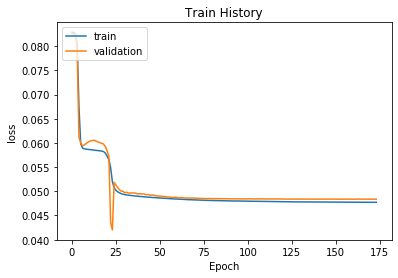

In [12]:
from obesity.model_evaluation import metric_array,show_train_history

show_train_history(e.model.history ,'loss','val_loss')

In [14]:
e.summary(show_detail=True)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5241, 11)]        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57651)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              59035648  
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)              

In [15]:
layer_name = 'embedding'
intermediate_layer_model = Model(inputs=e.model.input,
                                 outputs=e.model.get_layer(layer_name).output)
#intermediate_output = intermediate_layer_model.predict(data)

In [24]:
intermediate_layer_model.save('model/autoencoder_embedding.h5')

(array([9.43300e+03, 2.54390e+05, 2.61697e+05, 1.81445e+05, 1.43337e+05,
        6.32880e+04, 1.59140e+04, 2.34400e+03, 2.28000e+02, 2.00000e+01]),
 array([-2.1651280e+00, -1.4430802e+00, -7.2103232e-01,  1.0154962e-03,
         7.2306335e-01,  1.4451112e+00,  2.1671591e+00,  2.8892069e+00,
         3.6112547e+00,  4.3333025e+00,  5.0553503e+00], dtype=float32),
 <a list of 10 Patch objects>)

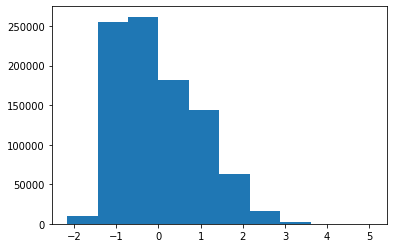

In [26]:
plt.hist(intermediate_layer_model.predict(valid_data_onehot).reshape(-1))

In [27]:
intermediate_layer_model.predict(valid_data_onehot)

array([[ 2.5654812 ,  0.30414417, -0.20220245, ...,  0.990989  ,
        -1.097013  , -0.52166194],
       [ 1.8264413 , -0.61609274, -0.52668625, ..., -0.15971403,
        -0.9907142 ,  0.3674222 ],
       [ 1.8611195 , -0.6060453 , -0.05250496, ..., -0.23037353,
        -0.8477092 , -0.32546228],
       ...,
       [ 1.0895673 , -0.84726864, -0.29234987, ..., -0.4710806 ,
         0.00803163, -0.10983738],
       [ 0.44981602, -0.20264295,  0.26877716, ..., -0.40361053,
        -0.47618154, -0.36361402],
       [ 0.78749216,  1.2145939 ,  0.8789628 , ...,  2.2844737 ,
        -0.8300529 , -0.46888575]], dtype=float32)

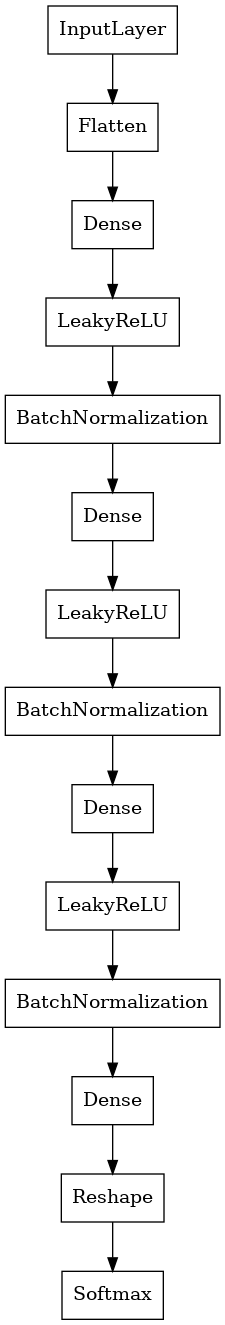

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(e.model, show_layer_names=False, to_file='autoencoder.png')